In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import scipy.io
import numpy as np
import h5py

import EMGfilter
import NeorecFiltering

def imagesc(x):
    plt.imshow(x,extent = [0,1,0,1])

def plotEnv(data, col=0, dif=0):
    if not dif:
        dif=np.max(np.var(data,0)/10)
    for i in range(data.shape[1]):
        if col:
            plt.plot(data[:,i]+dif*i, color=col)
        else:
            plt.plot(data[:,i]+dif*i)
            
def trialSuccess(posx,posy,par):
    outerR=200
    circleR=50
    maxPar=8
    circleY=outerR*np.sin(2*np.pi/maxPar*par)
    circleX=outerR*np.cos(2*np.pi/maxPar*par)
    
    for i in range(posx.shape[0]):
        if((posx[i]-circleX)**2+(posy[i]-circleY)**2<circleR**2):
            return 1
    return 0


In [3]:
srate = 512

In [4]:
workdir='data\\CO_80trials_van_10-01_17-16-52\\'

center_out = 0

#datafiles={'rot':'experiment_data_rot1.h5','van':'experiment_data_van1.h5'}
#datafile=datafiles['rot']

datafile='experiment_data.h5'

filepath = workdir + datafile
filepath

'data\\CO_80trials_van_10-01_17-16-52\\experiment_data.h5'

In [5]:
with h5py.File(filepath,'r+') as f1:
    print(list(f1.keys()))
    print(list(f1['protocol1'].keys()))

['channels', 'fs', 'protocol0', 'protocol1', 'settings.xml', 'stream_info.xml']
['mark_data', 'par_data', 'posx_data', 'posy_data', 'raw_data', 'raw_other_data', 'reward_data', 'signals_data', 'signals_stats', 'state_data', 'timestamp_data']


In [6]:
with h5py.File(filepath,'r+') as f1:
    list(f1.keys())[0]
    
    raw_data = np.array(f1['protocol1']['raw_data'])

    posx_data_full = np.array(f1['protocol1']['posx_data'])
    posy_data_full = np.array(f1['protocol1']['posy_data'])

    state_data = np.array(f1['protocol1']['state_data'])
    par_data = np.array(f1['protocol1']['par_data'])

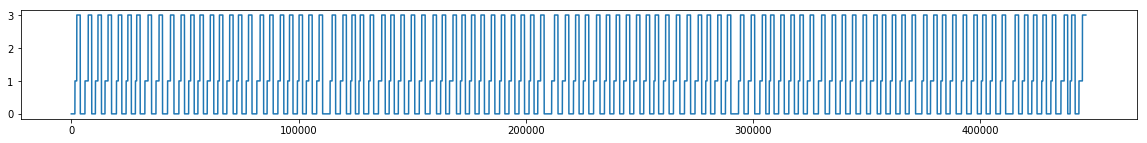

In [7]:
plt.rcParams['figure.figsize'] = [20, 2]
plt.plot(state_data[1000:srate*1500])

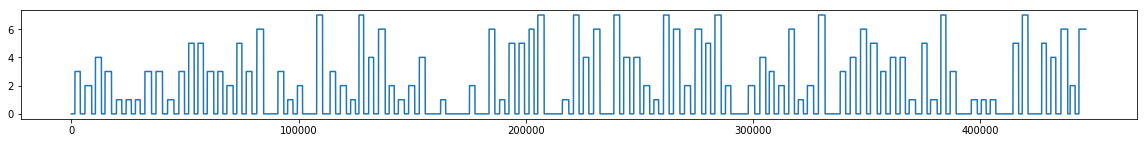

In [8]:
plt.rcParams['figure.figsize'] = [20, 2]
plt.plot(par_data[1000:srate*1500])

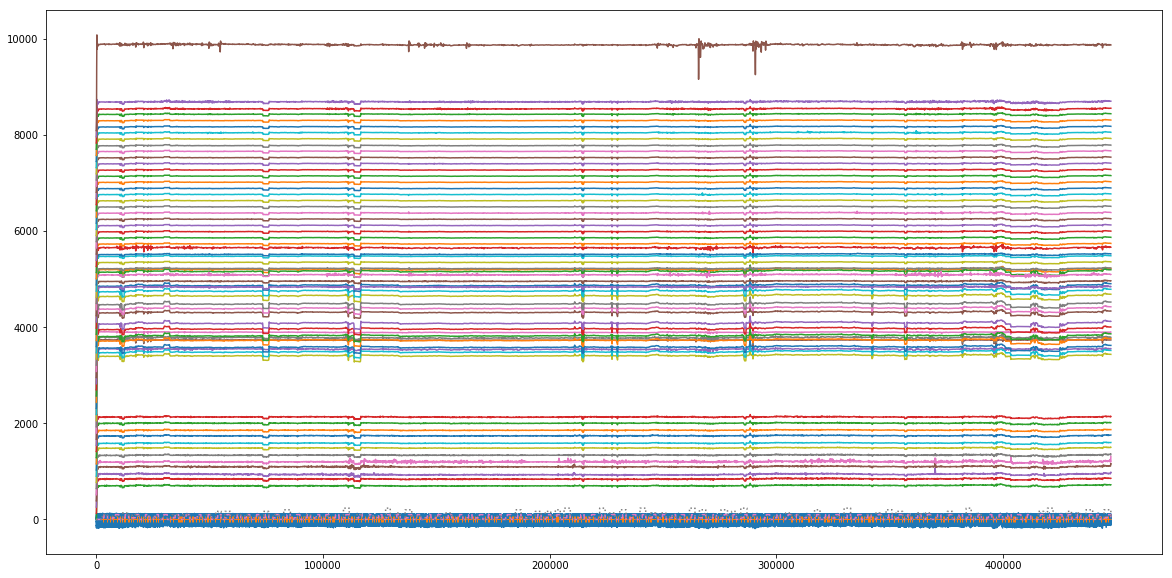

In [9]:
SampFreq = 512
myo_end = 64
t1 = 1
t2 = 3
byPhotoSensor = 0


plt.rcParams['figure.figsize'] = [20, 10]


with h5py.File(workdir+datafile,'r+') as f1:
    raw_data = np.array(f1['protocol1']['raw_data'])
    posx_data = np.array(f1['protocol1']['posx_data'])
    posy_data = np.array(f1['protocol1']['posy_data'])
    par_data = np.array(f1['protocol1']['par_data'])
    state_data = np.array(f1['protocol1']['state_data'])

myo=np.copy(raw_data[:,:myo_end])
myo=NeorecFiltering.CommonAverage(myo)
myo=EMGfilter.filterEMG(myo)

ran=range(0,50000)

par_data=np.array([p if p>-100 else 0 for p in par_data])
state_data=np.array([p if p>-100 else 0 for p in state_data])
photo_data=raw_data[:,14]-raw_data[:,12]

sph=500
mph=250
photo_points=[np.mean(photo_data[i-sph:i+sph]) for i in range(sph,len(photo_data)-sph)]
photo_points=[i for i in range(mph,len(photo_points)-mph) if photo_points[i]==min(photo_points[i-mph:i+mph])]
photo_points=np.array(photo_points)

#%%
plt.figure()

plt.plot(photo_data/2,':')
plt.plot(photo_points,np.zeros(photo_points.shape[0]),'+')
plotEnv(myo)
ramp=np.mean(np.var(myo,0)/100)*myo.shape[1]
plt.plot(state_data*ramp/10,'--')
plt.plot(par_data*ramp/10,':')

#%%
if center_out:
    first_state=2
    second_state=3
else:
    first_state=1
    second_state=3

if byPhotoSensor:
    StateChangeInd=[i for i in photo_points]
else:
    StateChangeInd=[i for i in range(1,state_data.shape[0]) if state_data[i-1]==first_state and state_data[i]==second_state]

T1=t1*SampFreq
T2=t2*SampFreq

if StateChangeInd[0]-T1<0:
    StateChangeInd.pop(0)
if StateChangeInd[-1]+T2>myo.shape[0]:
    StateChangeInd.pop(-1)

SeqInd=[range(i-T1,i+T2) for i in StateChangeInd]

myoSeq=[myo[p] for p in SeqInd]
posXSeq=[posx_data[p] for p in SeqInd]
posYSeq=[posy_data[p] for p in SeqInd]

#if(center_out):
#    first_state=1
#    second_state=2
#    ParFrom=[par_data[i-1] for i in range(1,state_data.shape[0]) if state_data[i-1]==first_state and state_data[i]==second_state]
#    ParRot=[par_data[i+1] for i in StateChangeInd]
#    ParSeq=[(a + b) % 8 for a, b in zip(ParFrom, ParRot)]
#else:
ParSeq=[par_data[i+1] for i in StateChangeInd]

parSet=list(set(ParSeq))

colset=[tuple(np.random.rand(3)) for p in parSet]







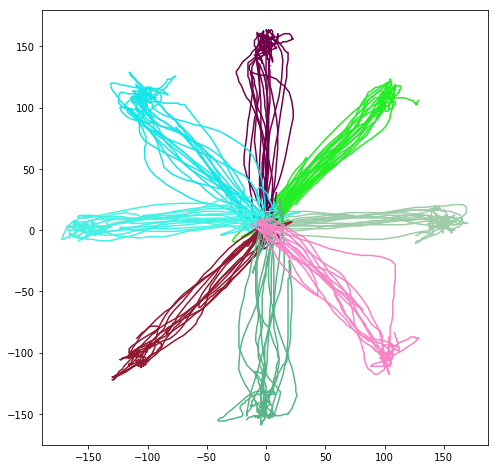

In [10]:
#%%

plt.rcParams['figure.figsize'] = [8, 8]

plt.figure()
for k,p in enumerate(parSet):
    colour=colset[k]
    colset.append(colour)
    for i in [j for j, pp in enumerate(ParSeq) if pp==p]:
        plt.plot(posXSeq[i],posYSeq[i],color=colour)




accuracy is  80.81 %


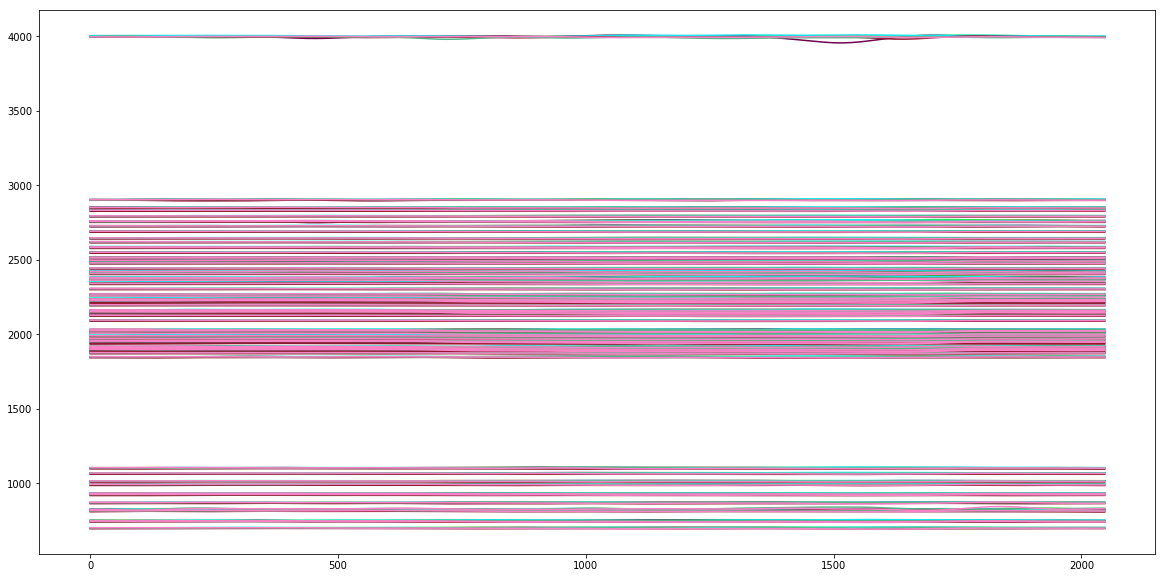

In [11]:
#%%
plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
globdif=np.max(np.var(myo[1000:,:],0))/20
k = 1
for j, p in enumerate(parSet):
    #plt.subplot(12,1,k)
    colour=colset[j]
    parSetInd=[j for j, pp in enumerate(ParSeq) if pp==p]
    myoParSet=np.mean(np.array([myoSeq[i] for i in parSetInd]),0)
    plotEnv(myoParSet,colour,globdif)    

#%%
hits=0
for i,p in enumerate(ParSeq):
    hits+=trialSuccess(posXSeq[i],posYSeq[i],p)
print('accuracy is ',round(hits/len(ParSeq)*100,2),'%')

#%%


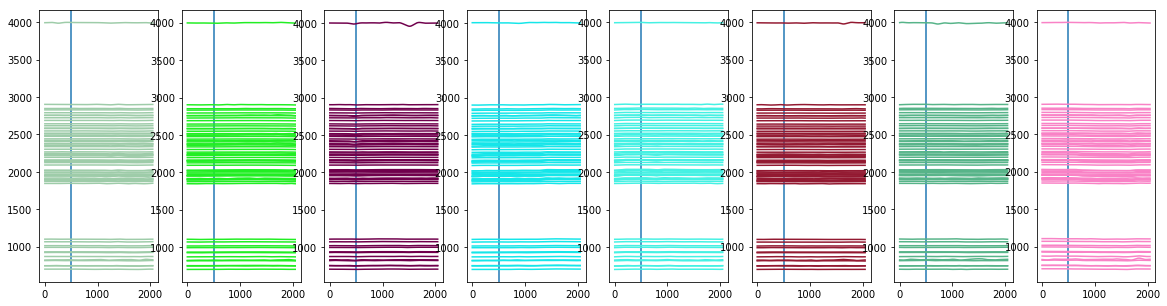

In [12]:
plt.rcParams['figure.figsize'] = [20, 5]
k = 1
for j, p in enumerate(parSet):
    if(center_out):
        plt.subplot(1,4,k)
    else:
        plt.subplot(1,8,k)
    colour=colset[j]
    plt.axvline(x=500)
    parSetInd=[j for j, pp in enumerate(ParSeq) if pp==p]
    myoParSet=np.mean(np.array([myoSeq[i] for i in parSetInd]),0)
    plotEnv(myoParSet,colour,globdif)    
    k = k+1
